In [1]:
%matplotlib inline


# Light curves

Compute per-observation and nightly fluxes of four Crab nebula observations.

## Prerequisites

-  Knowledge of the high level interface to perform data reduction, see
   :doc:`/tutorials/starting/analysis_1` tutorial.

## Context

This tutorial presents how light curve extraction is performed in
gammapy, i.e. how to measure the flux of a source in different time
bins.

Cherenkov telescopes usually work with observing runs and distribute
data according to this basic time interval. A typical use case is to
look for variability of a source on various time binnings: observation
run-wise binning, nightly, weekly etc.

**Objective: The Crab nebula is not known to be variable at TeV
energies, so we expect constant brightness within statistical and
systematic errors. Compute per-observation and nightly fluxes of the
four Crab nebula observations from the H.E.S.S. first public test data
release**\ [o](https://www.mpi-hd.mpg.de/hfm/HESS/pages/dl3-dr1/)_\ **to
check it.**

## Proposed approach

We will demonstrate how to compute a light curve from 3D reduced
datasets (`~gammapy.datasets.MapDataset`) as well as 1D ON-OFF
spectral datasets (`~gammapy.datasets.SpectrumDatasetOnOff`).

The data reduction will be performed with the high level interface for
the data reduction. Then we will use the
`~gammapy.estimators.LightCurveEstimator` class, which is able to
extract a light curve independently of the dataset type.


## Setup

As usual, we’ll start with some general imports…




In [2]:
import logging
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.time import Time

# %matplotlib inline
import matplotlib.pyplot as plt
from IPython.display import display
from gammapy.analysis import Analysis, AnalysisConfig
from gammapy.estimators import LightCurveEstimator
from gammapy.modeling.models import (
    Models,
    PointSpatialModel,
    PowerLawSpectralModel,
    SkyModel,
)

log = logging.getLogger(__name__)

## Check setup



In [3]:
from gammapy.utils.check import check_tutorials_setup

check_tutorials_setup()

198MB [00:28, 7.17MB/s]                                                         



*** You might want to declare GAMMAPY_DATA env variable
export GAMMAPY_DATA=gammapy-data/1.0.1


System:

	python_executable      : /Users/Leo/opt/anaconda3/bin/python 
	python_version         : 3.9.12     
	machine                : x86_64     
	system                 : Darwin     


Gammapy package:

	version                : 1.0.1      
	path                   : /Users/Leo/opt/anaconda3/lib/python3.9/site-packages/gammapy 


Other packages:

	numpy                  : 1.21.5     
	scipy                  : 1.7.3      
	astropy                : 5.0.4      
	regions                : 0.7        
	click                  : 8.0.4      
	yaml                   : 6.0        
	IPython                : 8.2.0      
	jupyterlab             : 3.3.2      
	matplotlib             : 3.5.1      
	pandas                 : 1.4.2      
	healpy                 : not installed 
	iminuit                : 2.21.3     
	sherpa                 : not installed 
	naima                  : not installed 
	emcee    

In [5]:
import os
os.environ['GAMMAPY_DATA'] = './gammapy-data/1.0.1'

! echo $GAMMAPY_DATA

./gammapy-data/1.0.1


## Analysis configuration

For the 1D and 3D extraction, we will use the same CrabNebula
configuration than in the :doc:`/tutorials/starting/analysis_1` tutorial
using the high level interface of Gammapy.

From the high level interface, the data reduction for those observations
is performed as followed




### Building the 3D analysis configuration




In [6]:
conf_3d = AnalysisConfig()

#### Definition of the data selection

Here we use the Crab runs from the HESS DL3 data release 1




In [7]:
conf_3d.observations.obs_ids = [23523, 23526, 23559, 23592]

#### Definition of the dataset geometry




In [8]:
# We want a 3D analysis
conf_3d.datasets.type = "3d"

# We want to extract the data by observation and therefore to not stack them
conf_3d.datasets.stack = False

# Here is the WCS geometry of the Maps
conf_3d.datasets.geom.wcs.skydir = dict(
    frame="icrs", lon=83.63308 * u.deg, lat=22.01450 * u.deg
)
conf_3d.datasets.geom.wcs.binsize = 0.02 * u.deg
conf_3d.datasets.geom.wcs.width = dict(width=1 * u.deg, height=1 * u.deg)

# We define a value for the IRF Maps binsize
conf_3d.datasets.geom.wcs.binsize_irf = 0.2 * u.deg

# Define energy binning for the Maps
conf_3d.datasets.geom.axes.energy = dict(min=0.7 * u.TeV, max=10 * u.TeV, nbins=5)
conf_3d.datasets.geom.axes.energy_true = dict(min=0.3 * u.TeV, max=20 * u.TeV, nbins=20)

### Run the 3D data reduction




In [9]:
analysis_3d = Analysis(conf_3d)
analysis_3d.get_observations()
analysis_3d.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4
Creating reference dataset and makers.
Creating the background Maker.
No background maker set. Check configuration.
Start the data reduction loop.
Computing dataset for observation 23523
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 23526
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 23559
Running MapDatasetMaker
Running SafeMaskMaker
Computing dataset for observation 23592
Running MapDatasetMaker
Running SafeMaskMaker


### Define the model to be used

Here we don’t try to fit the model parameters to the whole dataset, but
we use predefined values instead.




In [10]:
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit="deg")
spatial_model = PointSpatialModel(
    lon_0=target_position.ra, lat_0=target_position.dec, frame="icrs"
)

spectral_model = PowerLawSpectralModel(
    index=2.702,
    amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_model = SkyModel(
    spatial_model=spatial_model, spectral_model=spectral_model, name="crab"
)

We assign them the model to be fitted to each dataset




In [11]:
models = Models([sky_model])
analysis_3d.set_models(models)

Reading model.
Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : PointSpatialModel
  Temporal model type       : 
  Parameters:
    index                         :      2.702   +/-    0.00             
    amplitude                     :   4.71e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         
    lon_0                         :     83.633   +/-    0.00 deg         
    lat_0                         :     22.015   +/-    0.00 deg         

Component 1: FoVBackgroundModel

  Name                      : RNnvNt57-bkg
  Datasets names            : ['RNnvNt57']
  Spectral model type       : PowerLawNormSpectralModel
  Parameters:
    norm                          :      1.000   +/-    0.00             
    tilt                  (frozen):      0.000                   
    reference             (frozen):      1.0

## Light Curve estimation by observation

We can now create the light curve estimator.

We pass it the list of datasets and the name of the model component for
which we want to build the light curve. In a given time bin, the only
free parameter of the source is its normalization. We can optionally ask
for parameters of other model components to be reoptimized during fit,
that is most of the time to fit background normalization in each time
bin.

If we don’t set any time interval, the
`~gammapy.estimators.LightCurveEstimator` is determines the flux of
each dataset and places it at the corresponding time in the light curve.
Here one dataset equals to one observing run.




In [12]:
lc_maker_3d = LightCurveEstimator(
    energy_edges=[1, 10] * u.TeV, source="crab", reoptimize=False
)
# Example showing how to change some parameters from the object itself
lc_maker_3d.n_sigma_ul = 3  # Number of sigma to use for upper limit computation
lc_maker_3d.selection_optional = (
    "all"  # Add the computation of upper limits and likelihood profile
)
lc_3d = lc_maker_3d.run(analysis_3d.datasets)

The LightCurve object contains a table which we can explore.




time_min,time_max,e_min [1],e_max [1],flux [1],flux_err [1]
,,TeV,TeV,1 / (cm2 s),1 / (cm2 s)
float64,float64,float64,float64,float64,float64
53343.922340092584,53343.94186555555,1.191457161449437,10.000000000000002,2.0380210570069113e-11,2.1205834219790663e-12
53343.954215092584,53343.97369425925,1.191457161449437,10.000000000000002,2.06109536341573e-11,2.1406685556769825e-12
53345.96198129629,53345.98149518518,1.191457161449437,10.000000000000002,2.1806916496668676e-11,2.7893714968925812e-12
53347.91319657407,53347.932710462956,1.191457161449437,10.000000000000002,2.5084878954147826e-11,2.9141724802594204e-12


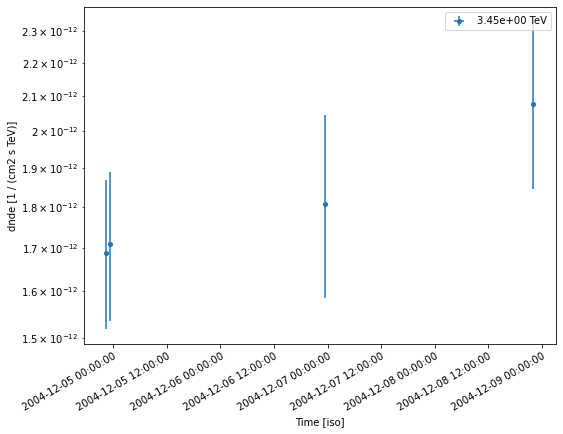

In [13]:
# Example showing how to change just before plotting the threshold on the signal significance
# (points vs upper limits), even if this has no effect with this data set.
fig, ax = plt.subplots(
    figsize=(8, 6),
    gridspec_kw={"left": 0.16, "bottom": 0.2, "top": 0.98, "right": 0.98},
)
lc_3d.sqrt_ts_threshold_ul = 5
lc_3d.plot(ax=ax, axis_name="time")

table = lc_3d.to_table(format="lightcurve", sed_type="flux")
display(table["time_min", "time_max", "e_min", "e_max", "flux", "flux_err"])

## Running the light curve extraction in 1D




### Building the 1D analysis configuration




In [14]:
conf_1d = AnalysisConfig()

#### Definition of the data selection

Here we use the Crab runs from the HESS DL3 data release 1




In [15]:
conf_1d.observations.obs_ids = [23523, 23526, 23559, 23592]

#### Definition of the dataset geometry




In [16]:
# We want a 1D analysis
conf_1d.datasets.type = "1d"

# We want to extract the data by observation and therefore to not stack them
conf_1d.datasets.stack = False

# Here we define the ON region and make sure that PSF leakage is corrected
conf_1d.datasets.on_region = dict(
    frame="icrs",
    lon=83.63308 * u.deg,
    lat=22.01450 * u.deg,
    radius=0.1 * u.deg,
)
conf_1d.datasets.containment_correction = True

# Finally we define the energy binning for the spectra
conf_1d.datasets.geom.axes.energy = dict(min=0.7 * u.TeV, max=10 * u.TeV, nbins=5)
conf_1d.datasets.geom.axes.energy_true = dict(min=0.3 * u.TeV, max=20 * u.TeV, nbins=20)

### Run the 1D data reduction




In [17]:
analysis_1d = Analysis(conf_1d)
analysis_1d.get_observations()
analysis_1d.get_datasets()

Setting logging config: {'level': 'INFO', 'filename': None, 'filemode': None, 'format': None, 'datefmt': None}
Fetching observations.
Observations selected: 4 out of 4.
Number of selected observations: 4
Reducing spectrum datasets.
Creating the background Maker.
No background maker set. Check configuration.


### Define the model to be used

Here we don’t try to fit the model parameters to the whole dataset, but
we use predefined values instead.




In [18]:
target_position = SkyCoord(ra=83.63308, dec=22.01450, unit="deg")

spectral_model = PowerLawSpectralModel(
    index=2.702,
    amplitude=4.712e-11 * u.Unit("1 / (cm2 s TeV)"),
    reference=1 * u.TeV,
)

sky_model = SkyModel(spectral_model=spectral_model, name="crab")

We assign the model to be fitted to each dataset. We can use the same
`~gammapy.modeling.models.SkyModel` as before.




In [19]:
models = Models([sky_model])
analysis_1d.set_models(models)

Reading model.
Models

Component 0: SkyModel

  Name                      : crab
  Datasets names            : None
  Spectral model type       : PowerLawSpectralModel
  Spatial  model type       : 
  Temporal model type       : 
  Parameters:
    index                         :      2.702   +/-    0.00             
    amplitude                     :   4.71e-11   +/- 0.0e+00 1 / (cm2 s TeV)
    reference             (frozen):      1.000       TeV         




### Extracting the light curve




In [20]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[1, 10] * u.TeV, source="crab", reoptimize=False
)
lc_1d = lc_maker_1d.run(analysis_1d.datasets)

print(lc_1d.geom.axes.names)

display(lc_1d.to_table(sed_type="flux", format="lightcurve"))

['energy', 'time']


time_min,time_max,e_ref [1],e_min [1],e_max [1],flux [1],flux_err [1],ts [1],sqrt_ts [1],"npred [1,4]","npred_excess [1,4]",stat [1],is_ul [1],"counts [1,4]",success [1]
,,TeV,TeV,TeV,1 / (cm2 s),1 / (cm2 s),,,,,,,,
float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,bool,float64,bool
53343.922340092584,53343.94186555555,3.4517490659800822,1.191457161449437,10.000000000000002,2.214391508228366e-11,2.460434388633055e-12,9669.93681384043,98.3358368746635,nan .. nan,nan .. nan,-344.4671903802651,False,nan .. nan,True
53343.954215092584,53343.97369425925,3.4517490659800822,1.191457161449437,10.000000000000002,1.8788302509394144e-11,2.2297607398492253e-12,8464.484921386465,92.00263540457124,nan .. 70.99962277926367,nan .. 70.99961853027344,-290.30784403249163,False,nan .. 71.0,True
53345.96198129629,53345.98149518518,3.4517490659800822,1.191457161449437,10.000000000000002,2.1553175393199613e-11,3.0180475424341633e-12,6065.962232361473,77.88428745492554,50.9994562190154 .. nan,50.999454498291016 .. nan,-194.37024721988718,False,51.0 .. nan,True
53347.91319657407,53347.932710462956,3.4517490659800822,1.191457161449437,10.000000000000002,2.4853673852981113e-11,3.2356719946290703e-12,7019.342401645411,83.78151587101662,nan .. nan,nan .. nan,-226.71637961887058,False,nan .. nan,True


### Compare results

Finally we compare the result for the 1D and 3D lightcurve in a single
figure:




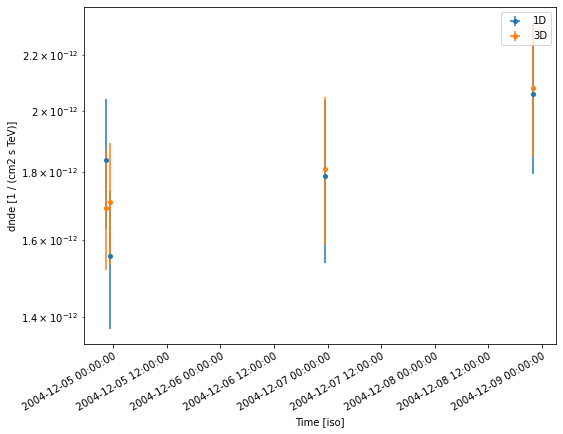

In [21]:
fig, ax = plt.subplots(
    figsize=(8, 6),
    gridspec_kw={"left": 0.16, "bottom": 0.2, "top": 0.98, "right": 0.98},
)
lc_1d.plot(ax=ax, marker="o", label="1D")
lc_3d.plot(ax=ax, marker="o", label="3D")
plt.legend()

## Night-wise LC estimation

Here we want to extract a night curve per night. We define the time
intervals that cover the three nights.




In [22]:
time_intervals = [
    Time([53343.5, 53344.5], format="mjd", scale="utc"),
    Time([53345.5, 53346.5], format="mjd", scale="utc"),
    Time([53347.5, 53348.5], format="mjd", scale="utc"),
]

To compute the LC on the time intervals defined above, we pass the
`LightCurveEstimator` the list of time intervals.

Internally, datasets are grouped per time interval and a flux extraction
is performed for each group.




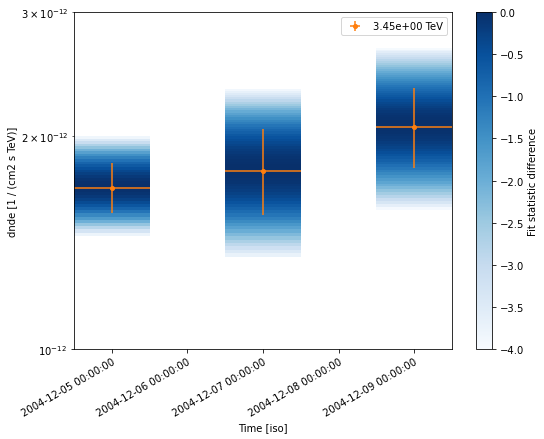

In [23]:
lc_maker_1d = LightCurveEstimator(
    energy_edges=[1, 10] * u.TeV,
    time_intervals=time_intervals,
    source="crab",
    reoptimize=False,
    selection_optional="all",
)

nightwise_lc = lc_maker_1d.run(analysis_1d.datasets)

fig, ax = plt.subplots(
    figsize=(8, 6),
    gridspec_kw={"left": 0.16, "bottom": 0.2, "top": 0.98, "right": 0.98},
)
nightwise_lc.plot(ax=ax, color="tab:orange")
nightwise_lc.plot_ts_profiles(ax=ax)
ax.set_ylim(1e-12, 3e-12)

plt.show()

## What next?

When sources are bright enough to look for variability at small time
scales, the per-observation time binning is no longer relevant. One can
easily extend the light curve estimation approach presented above to any
time binning. This is demonstrated in the :doc:`/tutorials/analysis-time/light_curve_flare`
tutorial. which shows the extraction of the lightcurve of an AGN flare.


